In [1]:
from unet.model import TomatoLeafModel
from torchsummary import summary
from utils.data_loading import transform_image_size
import torch
import matplotlib.pyplot as plt

IMAGE_HEIGHT = 1400
IMAGE_WIDTH = 875
SCALE = 32

/home/nick12138/anaconda3/envs/rotten-tomatoes/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
model = TomatoLeafModel().to(device)
# summary(model, input_size=(3, transform_image_size(IMAGE_HEIGHT, SCALE), transform_image_size(IMAGE_WIDTH, SCALE)))
model.model.decoder.blocks[-1]

DecoderBlock(
  (conv1): Conv2dReLU(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (attention1): Attention(
    (attention): Identity()
  )
  (conv2): Conv2dReLU(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (attention2): Attention(
    (attention): Identity()
  )
)

In [22]:
def get_intermediate_activations(model, image):
    activations = {}

    # Hook for final encoder layer
    def hook_encoder(module, input, output):
        activations['encoder'] = output

    # Hook for final decoder layer
    def hook_decoder(module, input, output):
        activations['decoder'] = output

    # Register hooks
    decoder_layer = model.decoder.blocks[-1].conv2
    encoder_layer = model.encoder.conv1
    encoder_layer.register_forward_hook(hook_encoder)
    decoder_layer.register_forward_hook(hook_decoder)

    # Forward pass through the model
    with torch.no_grad():
        model(image)

    return activations

def visualize_feature_map(feature_map, title, channel=0):
    # avg_feature_map = torch.mean(feature_map.squeeze(0), dim=0).cpu().numpy()
    print(feature_map.shape)
    plt.figure(figsize=(6, 6))
    feature_map = feature_map.squeeze(0)
    plt.imshow(feature_map[channel].cpu().numpy(), cmap='viridis')
    plt.title(title)
    plt.colorbar()
    plt.show()

In [23]:
# data/test/leaf02.jpg
from utils.data_loading import forward_transform_image
from PIL import Image
import numpy as np

image = np.array(Image.open('data/test/leaf02.jpg'))
sample = forward_transform_image(image=image)

sample = sample['image'].unsqueeze(0).to(device)

sample.shape

torch.Size([1, 3, 1408, 896])

torch.Size([1, 64, 704, 448])


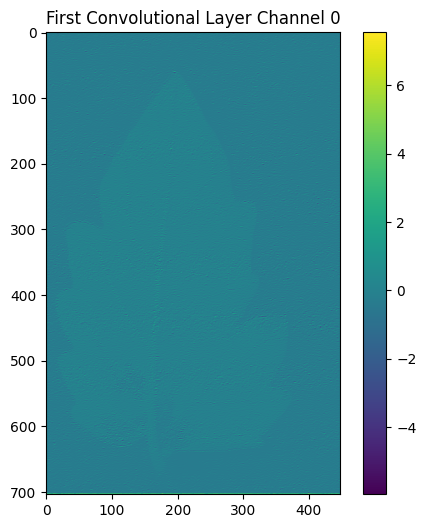

torch.Size([1, 64, 704, 448])


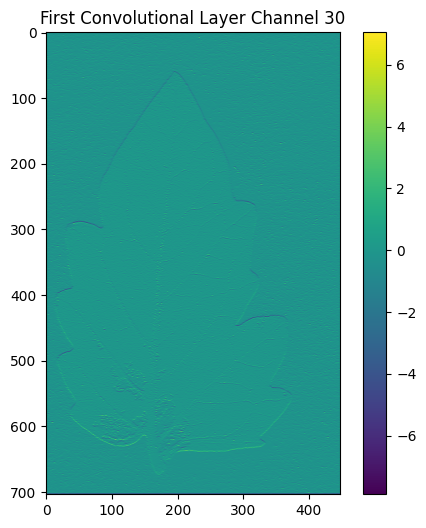

torch.Size([1, 64, 704, 448])


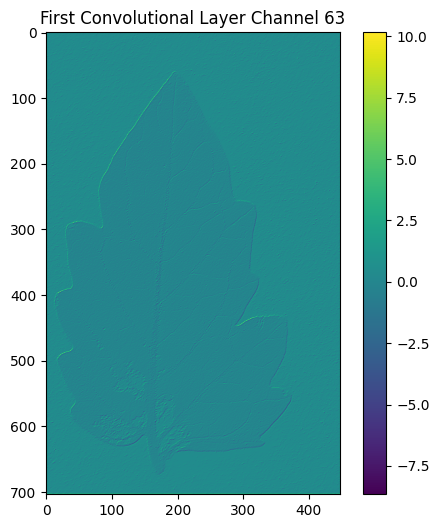

In [24]:
activations = get_intermediate_activations(model.model, sample)
channels = [0, 30, 63]
for channel in channels:
    visualize_feature_map(activations['encoder'], f'First Convolutional Layer Channel {channel}', channel=channel)

In [25]:
activations['encoder'].shape

torch.Size([1, 64, 704, 448])

In [26]:
activations['decoder'].shape

torch.Size([1, 16, 1408, 896])

torch.Size([1, 16, 1408, 896])


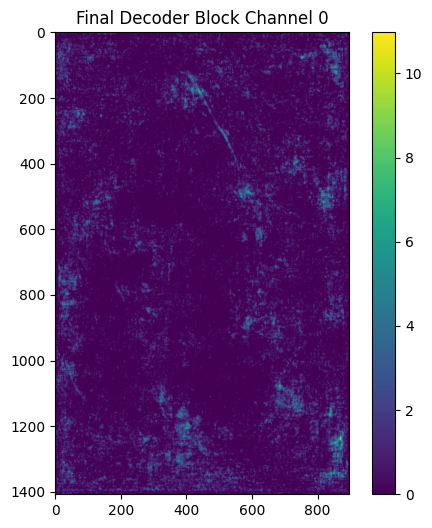

torch.Size([1, 16, 1408, 896])


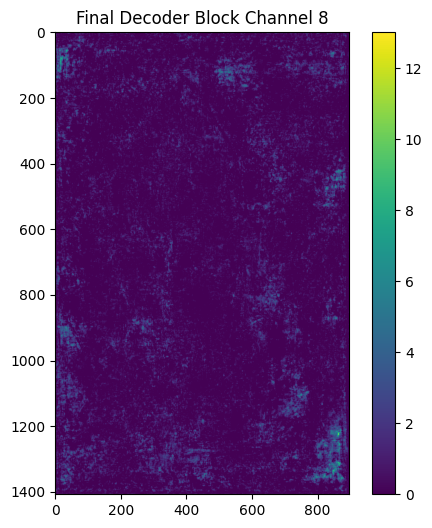

torch.Size([1, 16, 1408, 896])


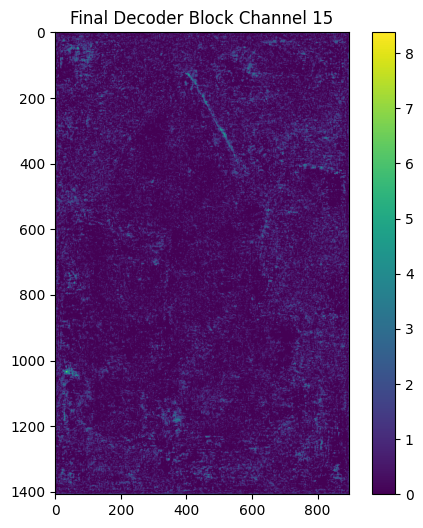

In [27]:
channels = [0, 8, 15]
for channel in channels:
    visualize_feature_map(activations['decoder'], f'Final Decoder Block Channel {channel}', channel=channel)

In [49]:
output = torch.sigmoid(activations['decoder'])

torch.Size([1, 16, 1408, 896])


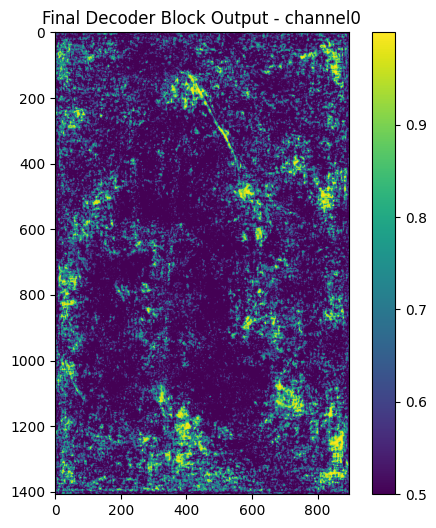

torch.Size([1, 16, 1408, 896])


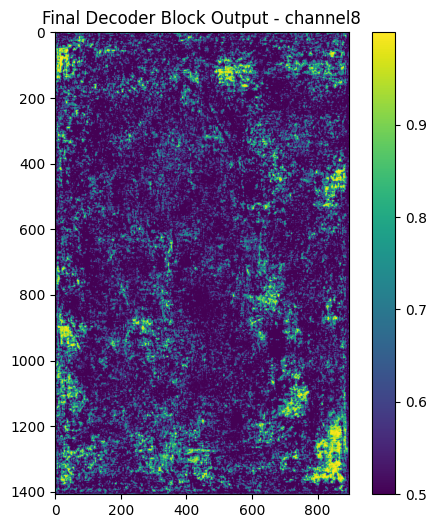

torch.Size([1, 16, 1408, 896])


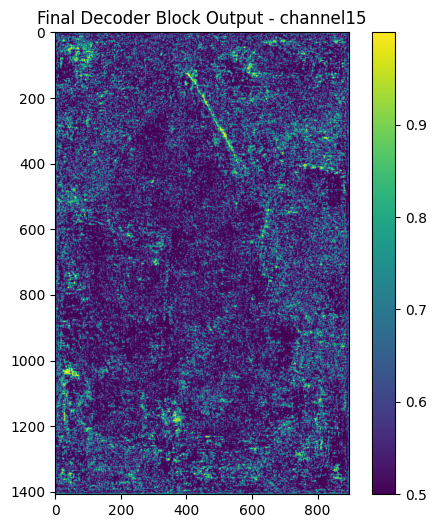

In [51]:
channels = [0, 8, 15]
for channel in channels:
    visualize_feature_map(output, f'Final Decoder Block Output - channel{channel}', channel=channel)